## Averaged flows


In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from scipy.ndimage import gaussian_filter
import os
import sys
sys.path.append('../vasco_scripts')  # add the relative path to the folder
from defects import *  # import the module from the folder
%matplotlib qt

def divergence_npgrad(flow):
    # flow = np.swapaxes(flow, 0, 1)
    Fx, Fy = flow[:, :, 0], flow[:, :, 1]
    dFx_dx = np.gradient(Fx, axis=0)
    dFy_dy = np.gradient(Fy, axis=1)
    return dFx_dx + dFy_dy


def analyze_defects(img):
    # Calculate mgrid
    yy, xx = np.mgrid[0:img.shape[0], 0:img.shape[1]]
    
    # Calculate orientation analysis
    ori, coh, E = orientation_analysis(img, 25)
    
    # Compute topological charges
    k = compute_topological_charges(-ori, int_area='cell', origin='lower')
    
    # Localize defects
    defects = localize_defects(k, x_grid=xx, y_grid=yy)
    
    # Compute defect orientation
    compute_defect_orientations(-ori, defects, method='interpolation', x_grid=xx[0,:], y_grid=yy[:,0], interpolation_radius=5, min_sep=1)
    
    # Filter defects by charge
    plushalf = defects[defects['charge']==.5]
    minushalf = defects[defects['charge']==-.5]
    
    return ori, plushalf, minushalf



# Defect dynamics time lapse

## Make dataframe with all defects and save as csv

In [ ]:
minushalf_df = pd.DataFrame([])
plushalf_df = pd.DataFrame([])

PLOT = True

# image_list = glob.glob(r"C:/Users/victo/Downloads/SB_lab/RPE1_C2C12_/Test001/*.tif")
image_list_all = glob.glob(r"C:\Users\victo\My Drive\Curie\Trinish\30_01_18_RPE1_C2C12_5x_phase_nuclei\*s14*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[50:200:1]

if PLOT:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.set_axis_off()
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

    # u = np.zeros_like(cv2.imread(image_list[0])[:,:,0], dtype=np.float32)
    # v = np.zeros_like(u)


for im1, im2 in zip(image_list[:-1], image_list[1:]):
    print(os.path.basename(im1))
    img1 = cv2.imread(im1)[:,:,0]
    
    # calculate velocity and plot fields
    if PLOT:
        ax.clear()
        img2 = cv2.imread(im2)[:,:,0]
        flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
            winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)  
        # >> uncomment to have average flow representation
        # >>  TO DO devide by number of frames
        # u += flow[..., 0]
        # v += flow[..., 1]
        # flow = np.stack((u, v), axis=-1)

        divergence = gaussian_filter(divergence_npgrad(flow), sigma=30)

        # Apply Contrast Limited Adaptive Histogram Equalization
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_clahe = clahe.apply(img1)
        ax.imshow(255-img_clahe, "gray")
        ax.imshow(divergence, "jet", alpha=.3, vmin=-0.03, vmax=0.03)

    ori, plushalf, minushalf = analyze_defects(img1)
    frame_num = int(os.path.splitext(os.path.basename(im1))[0].split("_t")[-1])
    minushalf['frame'] = frame_num
    plushalf['frame'] = frame_num
    minushalf_df = pd.concat([minushalf_df, minushalf], ignore_index=True)
    plushalf_df = pd.concat([plushalf_df, plushalf], ignore_index=True)
    
    if PLOT:
        alpha_half, scale_half = .9, 40    
        ax.plot(plushalf['x'], plushalf['y'],'ro',markersize=6, alpha=1)
        ax.quiver(plushalf['x'], plushalf['y'], 
            np.cos(plushalf['ang1']), -np.sin(plushalf['ang1']), 
            headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

        ax.plot(minushalf['x'], minushalf['y'],'bo',markersize=6, alpha=1)
        for i in range(3):
            ax.quiver(minushalf['x'], minushalf['y'], 
                np.cos(minushalf['ang'+str(i+1)]), -np.sin(minushalf['ang'+str(i+1)]), 
                headaxislength=0, headwidth=0, headlength=0, color='b', scale=scale_half, alpha=alpha_half)
    
    
        save_path = os.path.join(
            r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_", 
            'Nematic', 
            os.path.splitext(os.path.basename(im1))[0]
            )
    
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, bbox_inches=extent.expanded(1.15, 1.15))
    break    

# minushalf_df.to_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/MinusHalf1.csv')
# plushalf_df.to_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/PlusHalf1.csv')

In [ ]:
minushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/MinusHalf1.csv')
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/PlusHalf1.csv')

In [ ]:
import matplotlib

matplotlib.rc('axes', edgecolor='m')
plt.rcParams['xtick.color'] = 'm'
plt.rcParams['ytick.color'] = 'm'

frames = minushalf_df["frame"].unique()

fig, ax = plt.subplots(1,1, figsize=(12,12))
# ax.set_axis_off()
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# plt.tight_layout()
white_frame = np.ones((2048,2048,3))

for f in frames:
    
    minushalf = minushalf_df[minushalf_df["frame"]==f]
    plushalf = plushalf_df[plushalf_df["frame"]==f]
    
    alpha_half, scale_half = .9, 40   
    ax.clear() 
    # ax.imshow(white_frame, "gray")
    ax.plot(plushalf['x'], plushalf['y'],'r.',markersize=6, alpha=1)
    # ax.quiver(plushalf['x'], plushalf['y'], 
    #     np.cos(plushalf['ang1']), -np.sin(plushalf['ang1']), 
    #     headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

    ax.plot(minushalf['x'], minushalf['y'],'b.',markersize=6, alpha=1)
    # for i in range(3):
    #     ax.quiver(minushalf['x'], minushalf['y'], 
    #         np.cos(minushalf['ang'+str(i+1)]), -np.sin(minushalf['ang'+str(i+1)]), 
    #         headaxislength=0, headwidth=0, headlength=0, color='b', scale=scale_half, alpha=alpha_half)  

    save_path = os.path.join(
        r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_", 
        'Nematic3',
        'frame_' + str(f) + ".png"
        )
    # break
    ax.set_xlim([0, 2048])
    ax.set_ylim([0, 2048])
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path, bbox_inches=extent.expanded(1.15, 1.15))             


    # break



## Import CSVs

In [17]:
minushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/MinusHalf1.csv')
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/PlusHalf1.csv')

minushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/MinusTM_spots.csv', skiprows=[1,2,3])
plushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/PlusTM_spots.csv', skiprows=[1,2,3])

print("  ////////    PLUS   //////////")
print([(plushalf_TM[plushalf_TM["FRAME"]==i]).shape for i in range(10)])
print([(plushalf_df[plushalf_df["frame"]==i+51]).shape for i in range(10)])

print("\n ////////    MINUS   //////////")
print([(minushalf_TM[minushalf_TM["FRAME"]==i]).shape for i in range(10)])
print([(minushalf_df[minushalf_df["frame"]==i+51]).shape for i in range(10)])

  ////////    PLUS   //////////
[(83, 20), (83, 20), (77, 20), (78, 20), (73, 20), (73, 20), (73, 20), (69, 20), (71, 20), (66, 20)]
[(83, 10), (83, 10), (77, 10), (78, 10), (73, 10), (73, 10), (73, 10), (70, 10), (71, 10), (66, 10)]

 ////////    MINUS   //////////
[(82, 20), (80, 20), (79, 20), (78, 20), (72, 20), (70, 20), (72, 20), (70, 20), (71, 20), (64, 20)]
[(82, 10), (80, 10), (79, 10), (78, 10), (72, 10), (70, 10), (72, 10), (70, 10), (71, 10), (64, 10)]


## Find shift and rescale

slope: 2.2160783183618635 | intercept: -161.13420384246535
slope: 2.2160783183618635 | intercept: -161.13420384246535
slope: 2.2160372967706556 | intercept: -161.20313289755236
-------  X  ------------
slope: 2.2164830404297295 | intercept: -152.34319269178445
slope: 2.2164830404297295 | intercept: -152.34319269178445
slope: 2.2162957832623804 | intercept: -152.4206270246462
-------  Y  ------------


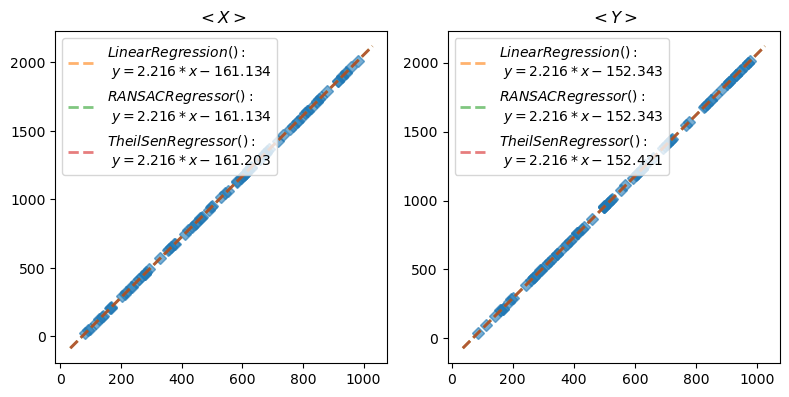

In [3]:
from sklearn import linear_model

%matplotlib inline
frame = 0

fig, axs = plt.subplots(1,2,  figsize=(8,16))

dims = ("x", "y")
lrs = (
    linear_model.LinearRegression(), 
    linear_model.RANSACRegressor(), 
    linear_model.TheilSenRegressor()
    )

for ax,dd in zip(axs, dims):
    X = plushalf_TM["POSITION_"+dd.upper()][plushalf_TM["FRAME"]==frame].iloc[:].sort_values().values
    y = plushalf_df[dd][plushalf_df["frame"]==51+frame].iloc[:]

    if dd=="y":
        y = (2048 - y) # y- values are flipped
    y = y.sort_values().values

    ax.plot(X, y, "D", alpha=.6)

    for lr in lrs:
        lr.fit(X.reshape(-1, 1), y)
        try:
            slope = lr.estimator_.coef_[0]
            intercept = lr.estimator_.intercept_
        except:
            slope = lr.coef_[0]
            intercept = lr.intercept_

        # use prints to set the SLOPE and INTERCEP globals in the next cell
        print('slope:', slope, '| intercept:', intercept)

        # prdict for line
        line_X = np.arange(X.min()-50, X.max()+50)[:, np.newaxis]
        line_y = lr.predict(line_X)

        ax.plot(line_X, line_y, "--", linewidth=2, alpha=.6,
                label="$%s:$\n $y= %.3f *x %.3f$" %(lr, slope, intercept))

    ax.set_title("$< %s >$" %dd.upper())

    ax.set_box_aspect(1)
    ax.legend(loc='upper left')
    print("-------  %s  ------------" %dd.upper())

plt.tight_layout()

### Validate shift and rescale

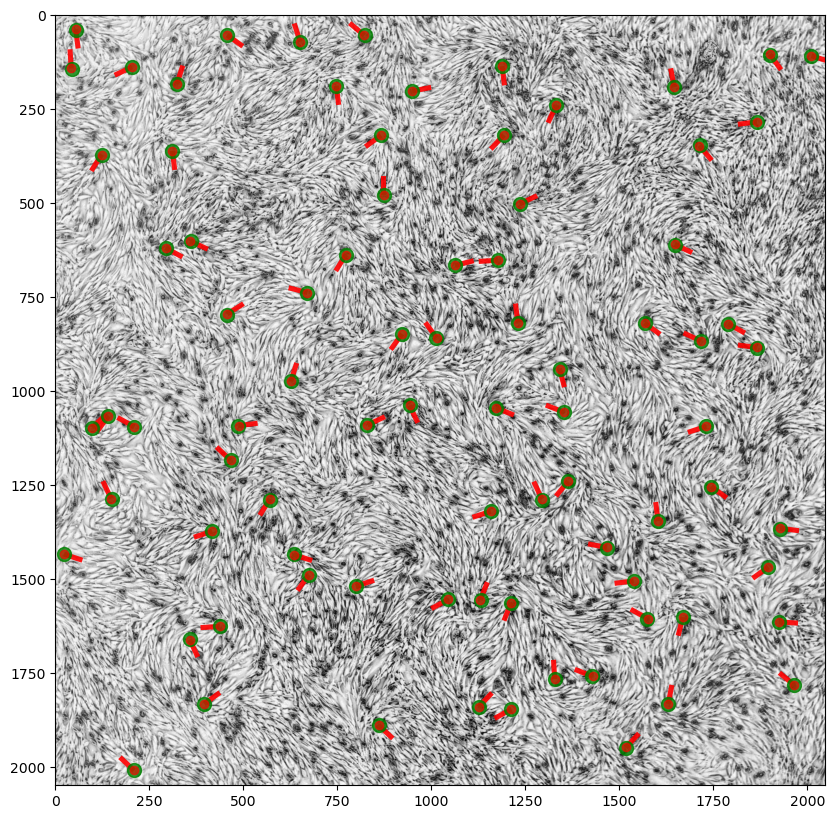

In [9]:
%matplotlib inline
SLOPEx = 2.2160372967706556
INTERCEPTx = -161.02498860090532
SLOPEy = 2.2160372967706556
INTERCEPTy = -152.4206270246462
frame = 0

image_list_all = glob.glob(r"C:\Users\victo\My Drive\Curie\Trinish\30_01_18_RPE1_C2C12_5x_phase_nuclei\*s14*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[50:200:1]
im1 = image_list[0]

plushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/PlusTM_spots.csv', skiprows=[1,2,3])
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/PlusHalf1.csv')

# Apply Contrast Limited Adaptive Histogram Equalization
img1 = cv2.imread(im1)[:,:,0]
h_img, w_img = img1.shape
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(255-img_clahe, "gray")

x = plushalf_TM["POSITION_X"][plushalf_TM["FRAME"]==frame].iloc[:].values * SLOPEx + INTERCEPTx
y = h_img - (plushalf_TM["POSITION_Y"][plushalf_TM["FRAME"]==frame].iloc[:].values * SLOPEy + INTERCEPTy)
ax.plot(x, y,'go',markersize=10, alpha=.8)

alpha_half, scale_half = .9, 40  
p_df =  plushalf_df[plushalf_df["frame"]==51+frame]
ax.plot(p_df['x'], p_df['y'],'ro',markersize=6, alpha=.6)
ax.quiver(p_df['x'], p_df['y'], 
    np.cos(p_df['ang1']), -np.sin(p_df['ang1']), 
    headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

### Apply angle information data to TrackMate DataFrame

In [80]:
%matplotlib qt
SLOPEx = 2.2160372967706556
INTERCEPTx = -161.02498860090532
SLOPEy = 2.2160372967706556
INTERCEPTy = -152.4206270246462

def center_pairs(Xlong, Xshort):
    '''find indexes of Xshort in Xlong'''
    from scipy import spatial
    tree = spatial.KDTree(Xlong)
    _, minid = tree.query(Xshort)   
    return minid

plushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/PlusTM_spots.csv', skiprows=[1,2,3])
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/PlusHalf1.csv')
minushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/MinusTM_spots.csv', skiprows=[1,2,3])
minushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/MinusHalf1.csv')

plushalf_TM["x_img"] = plushalf_TM["POSITION_X"] * SLOPEx + INTERCEPTx
plushalf_TM["y_img"] = h_img - (plushalf_TM["POSITION_Y"] * SLOPEy + INTERCEPTy)
minushalf_TM["x_img"] = minushalf_TM["POSITION_X"] * SLOPEx + INTERCEPTx
minushalf_TM["y_img"] = h_img - (minushalf_TM["POSITION_Y"] * SLOPEy + INTERCEPTy)

In [93]:
# find same dots and check
dfs_TM = [plushalf_TM, minushalf_TM]
dfs_ori = [plushalf_df, minushalf_df]

for df_TM, df_ori in zip(dfs_TM, dfs_ori):
    xy_ori = np.array([df_ori["x"], df_ori["y"]]).T
    xy_TM = np.array([df_TM["x_img"].values, df_TM["y_img"].values]).T
    idx = center_pairs(
        xy_ori, #Long Array
        xy_TM #Short Array
        ) 
    # break
    print(xy_ori[idx[100:103]],'\n', xy_TM[100:103],'\n', df_ori[['x', 'y']].loc[idx[100:103]].values)
    print("--------------")

    # replace and add angles
    df_TM[['x_img1','y_img1','ang1','ang2','ang3','charge']] =  df_ori[['x', 'y','ang1','ang2','ang3','charge']].iloc[idx[:]].values


[[ 291.  612.]
 [1062.  662.]
 [1184.  654.]] 
 [[ 291.04661994  611.52188524]
 [1062.22759922  662.49074307]
 [1184.10965054  653.62659388]] 
 [[ 291.  612.]
 [1062.  662.]
 [1184.  654.]]
--------------
[[1626. 1553.]
 [1557. 1556.]
 [1102. 1613.]] 
 [[1625.1010726  1553.33773637]
 [1556.4039164  1555.55377366]
 [1102.11627056 1613.17074338]] 
 [[1626. 1553.]
 [1557. 1556.]
 [1102. 1613.]]
--------------


In [51]:
# replace and add angles
plushalf_TM[['x_img1','y_img1','ang1','charge']] =  plushalf_df[['x', 'y', 'ang1', 'charge']].iloc[idx[:]].values

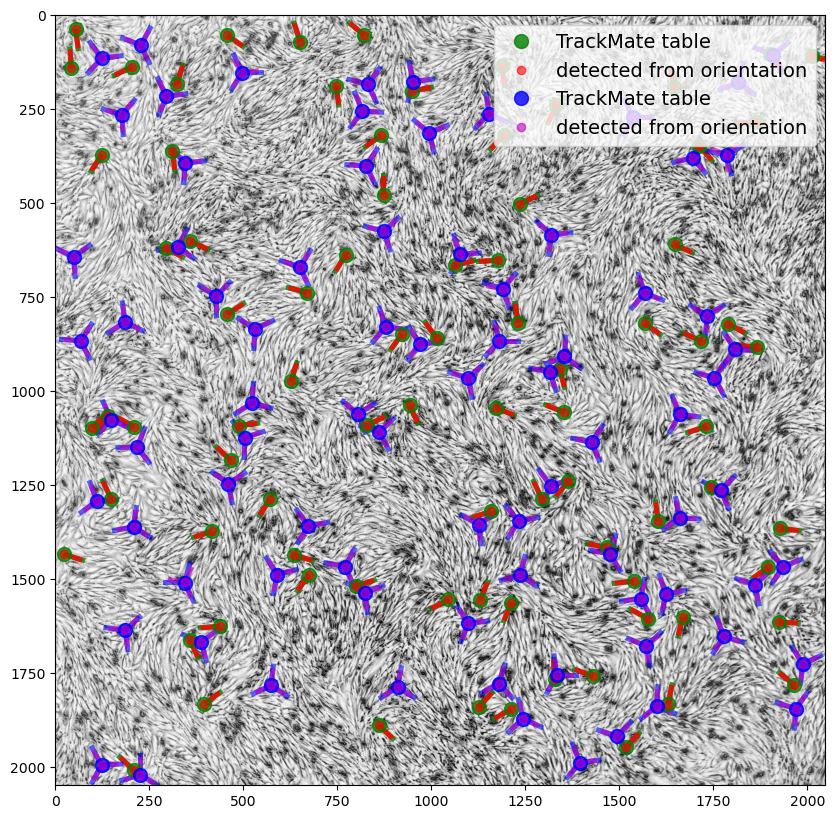

In [101]:
# test replaced values
%matplotlib inline
frame = 0

image_list_all = glob.glob(r"C:\Users\victo\My Drive\Curie\Trinish\30_01_18_RPE1_C2C12_5x_phase_nuclei\*s14*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[50:200:1]
im1 = image_list[frame]

# Apply Contrast Limited Adaptive Histogram Equalization
img1 = cv2.imread(im1)[:,:,0]
h_img, w_img = img1.shape
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(255-img_clahe, "gray")

# +1/2
idx = plushalf_TM["FRAME"]==frame
ax.plot(plushalf_TM["x_img1"][idx],
        plushalf_TM["y_img1"][idx],'go',
        markersize=10, alpha=.8, label="TrackMate table")
ax.quiver(plushalf_TM['x_img1'][idx], plushalf_TM['y_img1'][idx], 
    np.cos(plushalf_TM['ang1'][idx]), -np.sin(plushalf_TM['ang1'][idx]), 
    headaxislength=0, headwidth=0, headlength=0, color='g', scale=35, alpha=.8)        

p_df =  plushalf_df[plushalf_df["frame"]==51+frame]
ax.plot(p_df['x'], p_df['y'],'ro',markersize=6, alpha=.6, label="detected from orientation")
ax.quiver(p_df['x'], p_df['y'], 
    np.cos(p_df['ang1']), -np.sin(p_df['ang1']), 
    headaxislength=0, headwidth=0, headlength=0, color='r', scale=40, alpha=.8)

# -1/2
idx = minushalf_TM["FRAME"]==frame
ax.plot(minushalf_TM["x_img1"][idx],
        minushalf_TM["y_img1"][idx],'bo',
        markersize=10, alpha=.8, label="TrackMate table")
for i in range(3):
    ax.quiver(minushalf_TM["x_img1"][idx], minushalf_TM["y_img1"][idx], 
        np.cos(minushalf_TM['ang'+str(i+1)][idx]), -np.sin(minushalf_TM['ang'+str(i+1)][idx]), 
        headaxislength=0, headwidth=0, headlength=0, color='b', scale=35, alpha=.6)    

m_df =  minushalf_df[minushalf_df["frame"]==51+frame]
ax.plot(m_df['x'], m_df['y'],'mo',markersize=6, alpha=.6, label="detected from orientation")
for i in range(3):
    ax.quiver(m_df["x"], m_df["y"], 
        np.cos(m_df['ang'+str(i+1)][idx]), -np.sin(m_df['ang'+str(i+1)][idx]), 
        headaxislength=0, headwidth=0, headlength=0, color='m', scale=45, alpha=.6)    

ax.legend(loc='upper right', fontsize=14)

In [104]:
# Join TrackMate tabels for +1/2 and -1/2
pd.concat([plushalf_TM, minushalf_TM]).to_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_\PlusAndMinusTM.csv")

In [102]:
plushalf_TM[:2]

,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,CONTRAST_CH1,SNR_CH1,x_img,y_img,x_img1,y_img1,ang1,charge,ang2,ang3
0,ID398982,398982,75.0,81.421524,980.0,944.0,0.0,0.0,0,3.0,...,0.973672,1.625018,2010.691562,108.481419,2012.0,108.0,0.188496,0.5,NaN,NaN
1,ID398983,398983,NaN,73.580887,930.0,946.0,0.0,0.0,0,3.0,...,0.976583,1.294861,1899.889697,104.049344,1900.0,103.0,0.942478,0.5,NaN,NaN
